In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
movie_gross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
name_basics = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
title_basics = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
title_crew = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
title_principals = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
title_ratings = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
movie_info= pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
# rt_reviews= pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding='US_ASCII')
#this one is throwing errors for some reason, will return and do a more thorough check
budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

In [3]:
print(movie_gross.keys())
print(name_basics.keys())
print(title_basics.keys())
print(title_akas.keys())
print(title_crew.keys())
print(title_principals.keys())
print(title_ratings.keys())
print(movie_info.keys())
print(budgets.keys())


Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
Index(['nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles'],
      dtype='object')
Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')
Index(['title_id', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'is_original_title'],
      dtype='object')
Index(['tconst', 'directors', 'writers'], dtype='object')
Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object')
Index(['tconst', 'averagerating', 'numvotes'], dtype='object')
Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')


In [18]:
print(movie_gross.isna().sum())
print(name_basics.isna().sum())
print(title_basics.isna().sum())
print(title_akas.isna().sum())
print(title_crew.isna().sum())
print(title_principals.isna().sum())
print(title_ratings.isna().sum())
print(movie_info.isna().sum())
print(budgets.isna().sum())

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64
nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
known_for_titles       30204
dtype: int64
tconst                 0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64
title_id                  0
ordering                  0
title                     0
region                53293
language             289988
types                163256
attributes           316778
is_original_title        25
dtype: int64
tconst           0
directors     5727
writers      35883
dtype: int64
tconst             0
ordering           0
nconst             0
category           0
job           850502
characters    634826
dtype: int64
tconst           0
averagerating    0
numvotes         0
dtype: int64
id    

In [4]:
#converting all values in budgets sheets to ints by removing commas and $
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$' , '')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',', '')
budgets['domestic_gross'] = budgets['domestic_gross'].astype(int)

budgets['production_budget'] = budgets['production_budget'].str.replace('$' , '')
budgets['production_budget'] = budgets['production_budget'].str.replace(',', '')
budgets['production_budget'] = budgets['production_budget'].astype(int)

budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$' , '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',', '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(int)
#creating new lines showing the difference between gross and cost, aka net
budgets['domestic_net']= budgets['domestic_gross']- budgets['production_budget']
budgets['worldwide_net']= budgets['worldwide_gross']- budgets['production_budget']

In [5]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_net,worldwide_net
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,335507625,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,-169536125,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-307237650,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,303181382,999721747


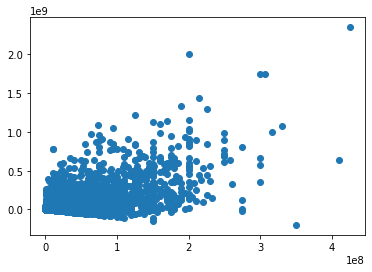

In [6]:
plt.scatter(x= budgets['production_budget'], y= budgets['worldwide_net'])